<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt
        $('div[style*="border-style: dashed"]').hide(); // hide extra comments, usually log from treasuredata
        $('div.output_stderr').parent().hide();

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import display, Math, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

sns.set_context('talk')
%matplotlib inline

# Introduction

## Background

Every company heavily relies on its customers: it's the core of the business. Losing the customers would damage the company's revenue stream. Thus, as an attempt to retain the customers, companies should know whether they need to give any treatments to their customers. However, it would be costly if all customers are treated similarly: there might be loyal customers (we don't need to give them extra discounts), while some others might be promo-hunters. In this analysis, we attempt to identify customers' probability to churn.

# Data Preparation

We create a **dummy** dataset of customer transactions in a ride-hailing company, which provides transportation services and food delivery (similar to Gojek, Grab, or Uber). We assume the monetary value is stored in IDR.

In [4]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [5]:
ACCOUNT_IDS = np.concatenate(
    (
        np.random.choice(np.arange(1,200), size=1000), ## random assignment for each user
        np.random.choice(np.arange(100,180), size=250) ## some users have more likelihood to repurchase
    )
)

PRODUCT_TYPES = np.concatenate(
    (
        np.random.choice(['FOOD','TRANSPORT'], p=[.4,.6], size=1000),
        np.random.choice(['FOOD','TRANSPORT'], p=[.6,.4], size=250),
    )
)

In [6]:
START_DATE = pd.to_datetime('2019-01-01')
END_DATE = pd.to_datetime('2020-02-01')

ORDER_TIMES = [random_date(START_DATE, END_DATE) for i in range(ACCOUNT_IDS.shape[0])]

# assumption: 
# order will be finished at least 5 minutes, at most at 90 minutes
ORDER_COMPLETION_SECONDS_RANGE = np.arange(300, 5400)
ORDER_COMPLETION_TIMES = [order_time + pd.to_timedelta(np.random.choice(ORDER_COMPLETION_SECONDS_RANGE), unit='second') for order_time in ORDER_TIMES]

In [7]:
df_customer_transaction = pd.DataFrame(
    data={
        'account_id': ACCOUNT_IDS,
        'product_type': PRODUCT_TYPES,
        'order_created_at': ORDER_TIMES,
        'order_completed_at': ORDER_COMPLETION_TIMES,
        'gross_amount': np.zeros(ACCOUNT_IDS.shape),
        'discount_percentage': np.zeros(ACCOUNT_IDS.shape),
        'discount_amount': np.zeros(ACCOUNT_IDS.shape),
        'paid_amount': np.zeros(ACCOUNT_IDS.shape)
    }
)

df_customer_transaction['order_duration'] = df_customer_transaction['order_completed_at'] - df_customer_transaction['order_created_at']

In [8]:
## assumption: 
## FOOD has higher gross amount than TRANSPORT

CONDITIONS = [
    df_customer_transaction['product_type'] == 'TRANSPORT',
    df_customer_transaction['product_type'] == 'FOOD'
]

GROSS_AMOUNT_CHOICES = [
    np.random.choice(np.arange(15000, 60000,3000)),
    np.random.choice(np.arange(25000, 250000,3000))
]

In [9]:
mask_product_type = (df_customer_transaction['product_type'] == 'TRANSPORT')

## transport
df_customer_transaction.loc[
    mask_product_type,
    'gross_amount'
] = np.random.choice(
    np.arange(15000, 150000, 3000),
    size=df_customer_transaction[mask_product_type].shape[0]
)

## food
df_customer_transaction.loc[
    ~mask_product_type,
    'gross_amount'
] = np.random.choice(
    np.arange(25000, 250000,3000),
    size=df_customer_transaction[~mask_product_type].shape[0]
)

In [10]:
## transport
df_customer_transaction.loc[
    mask_product_type,
    'discount_percentage'
] = np.random.choice(
    np.arange(0, 0.3, 0.05),
    size=df_customer_transaction[mask_product_type].shape[0]
)

## food
df_customer_transaction.loc[
    ~mask_product_type,
    'discount_percentage'
] = np.random.choice(
    np.arange(0, 0.5, 0.05),
    size=df_customer_transaction[~mask_product_type].shape[0]
)

df_customer_transaction['discount_amount'] = df_customer_transaction['discount_percentage'] * df_customer_transaction['gross_amount']
df_customer_transaction['paid_amount'] = df_customer_transaction['gross_amount'] - df_customer_transaction['discount_amount']

## assumption: original amount is 70% of the gross amount
df_customer_transaction['original_amount'] = df_customer_transaction['gross_amount'] * 0.7
df_customer_transaction['profit'] = df_customer_transaction['paid_amount'] - df_customer_transaction['original_amount']

In [12]:
print("Dataset preview")
display(df_customer_transaction.sample(3))

Dataset preview


,account_id,product_type,order_created_at,order_completed_at,gross_amount,discount_percentage,discount_amount,paid_amount,order_duration,original_amount,profit
363,142,TRANSPORT,2019-05-06 01:11:51,2019-05-06 01:42:42,123000.0,0.25,30750.0,92250.0,00:30:51,86100.0,6150.0
641,178,TRANSPORT,2019-03-22 14:28:13,2019-03-22 15:06:02,81000.0,0.25,20250.0,60750.0,00:37:49,56700.0,4050.0
1014,104,TRANSPORT,2019-11-13 20:59:42,2019-11-13 21:57:50,63000.0,0.20,12600.0,50400.0,00:58:08,44100.0,6300.0


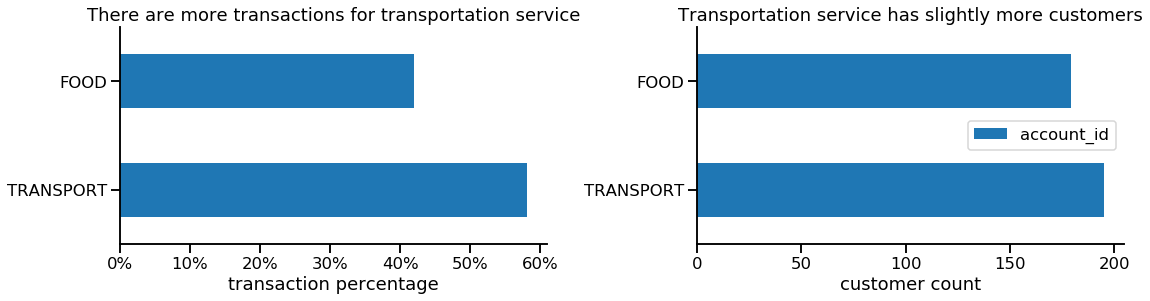

In [444]:
f, ax = plt.subplots(figsize=(18,4), ncols=2)
plt.subplots_adjust(wspace=.35)

df_customer_transaction['product_type'].value_counts(True).plot.barh(ax=ax[0]);
ax[0].set_title('There are more transactions for transportation service')
ax[0].set_xlabel('transaction percentage')
ax[0].set_xticklabels(['{:,.0%}'.format(x) for x in ax[0].get_xticks()])

df_customer_transaction.groupby(['product_type']).agg({
    'account_id': 'nunique'
}).sort_values(by='product_type', ascending=False).plot.barh(ax=ax[1]);
ax[1].set_ylabel('')
ax[1].set_title('Transportation service has slightly more customers')
ax[1].set_xlabel('customer count')

sns.despine()
plt.show();

Transportation service has lower transaction amount than food delivery, but it is more profitable.

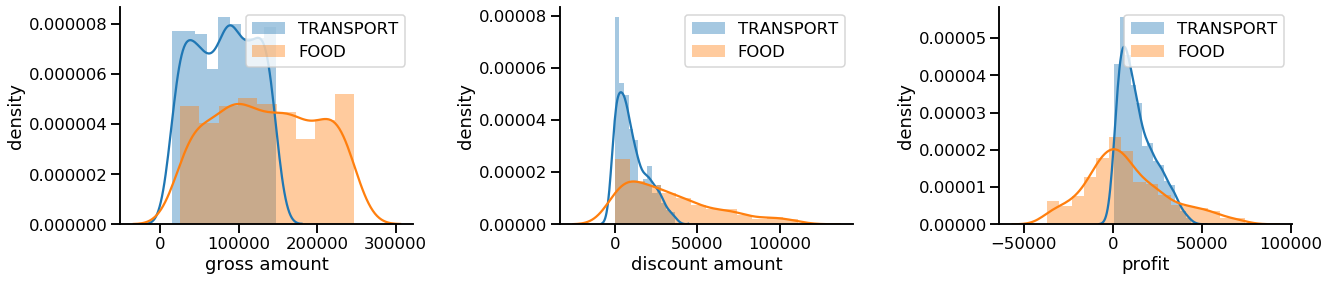

In [470]:
mask_product_type = (df_customer_transaction['product_type'] == 'TRANSPORT')
metrics = ['gross_amount','discount_amount','profit']

f, ax = plt.subplots(figsize=(21,4), ncols=3)
plt.subplots_adjust(wspace=.5)
i = 0

for metric in metrics:
    sns.distplot(
        df_customer_transaction[mask_product_type][metric],
        label='TRANSPORT',
        ax=ax[i]
    )

    sns.distplot(
        df_customer_transaction[~mask_product_type][metric],
        label='FOOD',
        ax=ax[i]
    );
    
    ax[i].set_xlabel(metric.replace('_',' '))
    ax[i].set_ylabel('density')
    ax[i].legend(loc='best')
    i += 1

sns.despine()
plt.show();

# Analysis

## 1st approach: Survival Analysis

We can estimate churn probability of the customers using survival function from Kaplan Meier Estimator. I have written a short introduction to this in [my blog post](https://elvyna.github.io/2018/survival-analysis-kaplan-meier/).

Here, we assume that the observation date is December 25, 2019.

In [115]:
OBSERVATION_DATE = '2019-12-25'

In [64]:
from lifelines import KaplanMeierFitter

def prepare_dataset_for_kmf(df, 
                            sort_key,
                            group_key,
                            observation_end_date,
                            order_time_col,
                            observed_duration_unit
                           ):
    df = df.sort_values(by=sort_key)
    df['next_'+order_time_col] = df.groupby(group_key)[order_time_col].shift(-1)
    df['interval_to_next_order'] = np.round((df['next_'+order_time_col] - df[order_time_col]) / np.timedelta64(1, observed_duration_unit))
    df['observed_duration'] = np.round(
        (pd.to_datetime(observation_end_date) - df[order_time_col])
        / np.timedelta64(1, observed_duration_unit)
    )
    
    df['duration'] = np.round(df[['observed_duration','interval_to_next_order']].min(axis=1))
    df['observed'] = (df['duration'] >= 0)
    return df

def calculate_survival_probability(df, duration_column='duration', observed_column='observed', show_plot=True):
    kmf = KaplanMeierFitter()    
    T = df[duration_column]
    E = df[observed_column]

    kmf.fit(T, event_observed=E)
    return kmf

In general, the customers are **likely to repurchase any products within 36 days after their previous purchase**. As the time goes, the repurchase probability goes down.

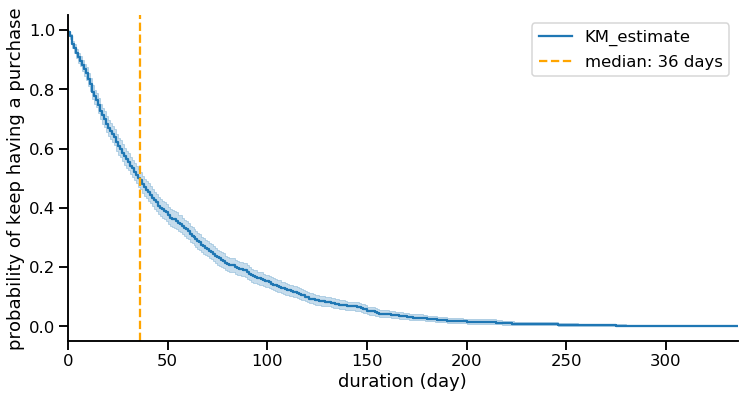

In [74]:
df_kmf_overall = prepare_dataset_for_kmf(
    df_customer_transaction,
    sort_key=['account_id','order_completed_at'],
    group_key=['account_id'],
    observation_end_date=OBSERVATION_DATE,
    order_time_col='order_completed_at',
    observed_duration_unit='D'
)

kmf_overall = calculate_survival_probability(
    df_kmf_overall, 
    duration_column='duration',
    observed_column='observed'
)

f, ax = plt.subplots(figsize=(12,6))
kmf_overall.plot(ax=ax);
plt.axvline(
    kmf_overall.median_survival_time_,
    linestyle='--',
    c='orange',
    label='median: {:.0f} days'.format(kmf_overall.median_survival_time_)
)

plt.legend(loc='best')
plt.xlim(0,)
plt.xlabel('duration (day)')
plt.ylabel('probability of keep having a purchase')
sns.despine()
plt.show();

We might need to reengage with customers of each products differently, since they might have different needs. Apparently, **customers who use transportation service are less likely to repurchase after 58 days; while food delivery customers can be retained in longer period (69 days)**. This might happen since transportation is considered more as daily needs: people commute every day; while less people need food delivery service.

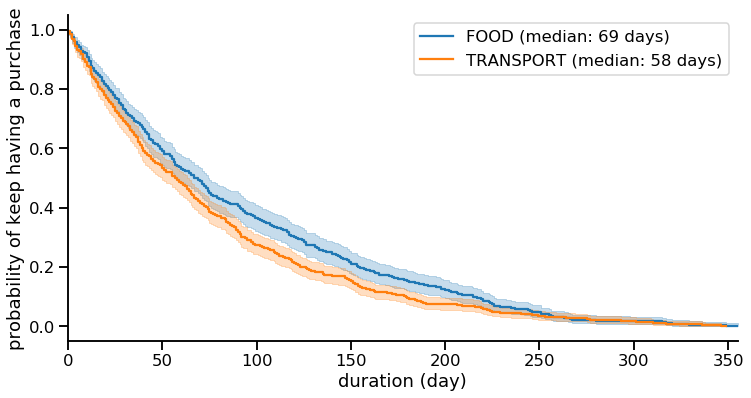

In [61]:
df_kmf_product_type = prepare_dataset_for_kmf(
    df_customer_transaction,
    sort_key=['account_id','order_completed_at'],
    group_key=['account_id','product_type'],
    observation_end_date=OBSERVATION_DATE,
    order_time_col='order_completed_at',
    observed_duration_unit='D'
)

product_types = []
f, ax = plt.subplots(figsize=(12,6))
for product_type, group in df_kmf_product_type.groupby('product_type'):
    kmf = calculate_survival_probability(
        group, 
        duration_column='duration',
        observed_column='observed'
    )
    kmf.plot(label='{} (median: {:.0f} days)'.format(product_type, kmf.median_survival_time_))
    product_types.append(
        (product_type, kmf.median_survival_time_)
    )
    
plt.xlabel('duration (day)')
plt.ylabel('probability of keep having a purchase')
sns.despine();

In [40]:
df_kmf_product_type['product_type_median'] = df_kmf_product_type['product_type'].map(dict(product_types))
df_kmf_product_type['is_likely_to_churn'] = df_kmf_product_type['duration'] > df_kmf_product_type['product_type_median']

Based on this findings, we could determine a customer as "likely to churn" if they haven't purchased after certain period (we'll use the median per product type).

In [177]:
last_transaction_per_product = df_kmf_product_type.groupby(['product_type','account_id']).tail(1).copy()

agg = last_transaction_per_product.groupby('product_type').agg({
    'is_likely_to_churn': 'sum',
    'account_id': 'count'
}).reset_index()
agg['percentage'] = agg['is_likely_to_churn'] / agg['account_id']

display(
    agg[['product_type','is_likely_to_churn','percentage']].style.format({
        'is_likely_to_churn': '{:.0f}',
        'percentage': '{:.2%}'
    })
)

,product_type,is_likely_to_churn,percentage
0,FOOD,76,42.46%
1,TRANSPORT,72,36.92%


## 2nd approach: [Buy 'Til You Die](https://en.wikipedia.org/wiki/Buy_Till_you_Die)

Prior to determining which engagement strategy should be done, it would be beneficial if we have better understanding of the customers. We could categorize them based on their lifetime value, i.e. monetary value during their period as a customer. With this information, we could put more effort in retaining customers with high lifetime value which are likely to churn.

We utilize GammaGammaFitter from [Lifetimes](https://lifetimes.readthedocs.io/en/latest/index.html) library to estimate average monetary value of each customers. The estimated value will be multiplied with the expected number of transactions from BetaGeoFitter model to get monthly expected monetary value. Using this value, we could determine low, mid, and high-valued customers.

BetaGeoFitter also could calculate the probability of customer being alive based on their historical purchase: their recency, frequency, and duration of being a customer. Here's the intuition: a customer who frequently purchases every 3 days, and becomes dormant (no transactions) in the past 2 weeks are more likely to churn, compared to a customer whose first purchase just happens 2 days ago.

We will analyze the customers separately based on the product type.

### Transportation

GammaGammaFitter results are aligned with customer's historical value, as seen on the distribution plot below.

In [486]:
from lifetimes.utils import summary_data_from_transaction_data

mask_transport = (df_customer_transaction['product_type'] == 'TRANSPORT')
df_transport_customer_summary = summary_data_from_transaction_data(
    df_customer_transaction[mask_transport],
    customer_id_col='account_id',
    datetime_col='order_completed_at',
    monetary_value_col='profit',
    observation_period_end=OBSERVATION_DATE
)

In [493]:
from lifetimes import GammaGammaFitter

def estimate_monetary_value(df, 
                            frequency_col,
                            monetary_value_col,
                            penalizer_coef=0.001,
                            show_plot=True):
    mask_nonzero_monetary_value = (df[monetary_value_col] > 0)
    ggf = GammaGammaFitter(penalizer_coef=penalizer_coef)
    ggf.fit(
        df[mask_nonzero_monetary_value][frequency_col],
        df[mask_nonzero_monetary_value][monetary_value_col]
    )
    
    conditional_expected_avg_monetary_value = ggf.conditional_expected_average_profit(
        df[frequency_col],
        df[monetary_value_col]
    )
    
    if show_plot:
        sns.distplot(
            conditional_expected_avg_monetary_value,
            label='expected'
        )

        sns.distplot(
            df[monetary_value_col],
            label='historical'
        )

        plt.xlabel('monetary value')
        plt.ylabel('density')
        sns.despine()

    print("""
    Expected conditional average profit: {:,.0f}
    Average historical value: {:,.0f}
    """.format(
        conditional_expected_avg_monetary_value.mean(),
        df[monetary_value_col].mean()
    ))

    df['expected_avg_profit'] = conditional_expected_avg_monetary_value
    return df, ggf


    Expected conditional average profit: 12,400
    Average historical value: 11,902
    


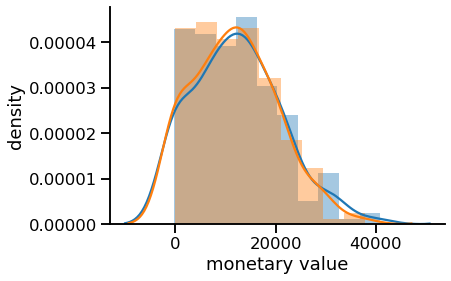

In [504]:
df_transport_customer_summary, ggf_transport = estimate_monetary_value(
    df_transport_customer_summary,
    frequency_col='frequency',
    monetary_value_col='monetary_value'
)

Priot to fitting the BetaGeoFitter model, we split the dataset into calibration (training) and holdout (test) set, with cut off on November 30, 2019. The BetaGeoFitter model underestimates number of transactions created during the training period: it predicts that there are more customers who don't have any purchase. Although it is not perfect, we could start with this - at least we have less wrong answers.

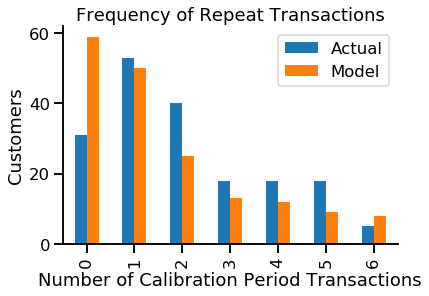

In [505]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter

transport_summary_calibration_holdout = calibration_and_holdout_data(
    df_customer_transaction[mask_transport],
    customer_id_col='account_id',
    datetime_col='order_completed_at',
    monetary_value_col='profit',
    calibration_period_end='2019-11-30',
    observation_period_end=OBSERVATION_DATE
)

bgf_transport = BetaGeoFitter(penalizer_coef=0.02)
bgf_transport.fit(
    transport_summary_calibration_holdout['frequency_cal'],
    transport_summary_calibration_holdout['recency_cal'], 
    transport_summary_calibration_holdout['T_cal']
);

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf_transport)
sns.despine();

Using the predicted number of purchases from BetaGeoFitter and estimated monetary value from GammaGammaFitter, we calculate the lifetime value of each customers. **~28% of transportation customers are high-valued**, with lifetime value >= IDR 136,853. Note that **all customers have positive lifetime value**.

In [506]:
df_transport_customer_summary['clv'] = ggf_transport.customer_lifetime_value(
    bgf_transport,
    df_transport_customer_summary['frequency'],
    df_transport_customer_summary['recency'],
    df_transport_customer_summary['T'],
    df_transport_customer_summary['monetary_value'],
    freq='D',
    time=30,
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

(-inf, 82583.109]          0.368098
(82583.109, 136852.349]    0.349693
(136852.349, inf]          0.282209
Name: clv, dtype: float64


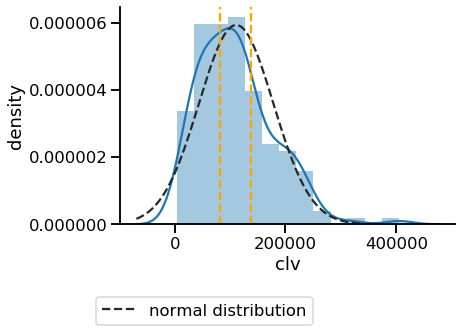

In [507]:
from scipy.stats import norm

transport_clv = df_transport_customer_summary['clv']

mask_transport_clv_wo_outliers = (transport_clv >= transport_clv.quantile(.005)) & (transport_clv <= transport_clv.quantile(.995))
transport_clv_wo_outliers = transport_clv[mask_transport_clv_wo_outliers]
cutoff1, cutoff2 = norm.ppf([1/3, 2/3], *norm.fit(transport_clv[mask_transport_clv_wo_outliers]))

df_transport_customer_summary['clv_segment'] = pd.cut(
    transport_clv, 
    [-np.inf, cutoff1, cutoff2, np.inf], 
    labels=['low','mid','high']
)

sns.distplot(
    transport_clv.dropna(),
    fit=norm,
    fit_kws={'label':'normal distribution', 'linestyle':'--'}
)

plt.axvline(cutoff1, linestyle='--', color='orange')
plt.axvline(cutoff2, linestyle='--', color='orange')

percentages = pd.cut(
    transport_clv, 
    [-np.inf, cutoff1, cutoff2, np.inf]
).value_counts(True).sort_index()

plt.legend(loc='lower center', bbox_to_anchor=[.25,-.5])
plt.ylabel('density')
sns.despine();

print(percentages)

As seen on the distribution plot, **majority of the customers are less likely to churn** (below 5% churn probability).

In [508]:
df_transport_customer_summary['churn_prob'] = 1 - bgf_transport.conditional_probability_alive(
        df_transport_customer_summary['frequency'],
        df_transport_customer_summary['recency'],
        df_transport_customer_summary['T']
    )

# df_transport_customer_summary.head()

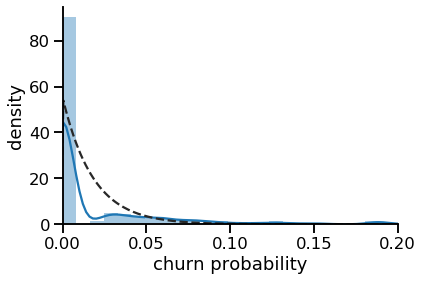

In [509]:
from scipy.stats import expon

sns.distplot(
    df_transport_customer_summary['churn_prob'],
    fit=expon,
    fit_kws={'linestyle':'--', 'label':'exponential distribution'}
);

plt.xlim(0,0.2)
plt.xlabel('churn probability')
plt.ylabel('density')
sns.despine();

Combining the estimated customer lifetime value and their churn probability, we could create a matrix containing the customer segments. We don't find any customers in the mid-churn probability, which means the segmentation results in six groups. As seen below, **~30% of the transportation customers have high probability to churn, and most of them are the low-valued ones**. It will be up to the business users to decide, whether we should put high effort to retain them or just let them go and focus on the more profitable customers.

In [510]:
transport_churn_prob = df_transport_customer_summary['churn_prob']

mask_transport_churn_prob_wo_outliers = (transport_churn_prob >= transport_churn_prob.quantile(.005)) & (transport_churn_prob <= transport_churn_prob.quantile(.995))
transport_churn_prob_wo_outliers = transport_churn_prob[mask_transport_churn_prob_wo_outliers]
cutoff1, cutoff2 = expon.ppf([1/3, 2/3], *expon.fit(transport_churn_prob[mask_transport_churn_prob_wo_outliers]))

df_transport_customer_summary['churn_segment'] = pd.cut(
    transport_churn_prob, 
    [-np.inf, cutoff1, cutoff2, np.inf], 
    labels=['low','mid','high']
)

In [511]:
def display_segmentation_matrix(df, pivot_value_col, pivot_index_col, pivot_col, 
                                plot_title, plot_xlabel, plot_ylabel):
    customer_pivot = pd.pivot_table(
        df,
        values=pivot_value_col,
        index=pivot_index_col,
        columns=pivot_col,
        aggfunc='count',
        fill_value=0
    ).sort_index(ascending=False)[['low','mid','high']]

    f, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(
        customer_pivot / customer_pivot.values.sum(),
        annot=True,
        fmt='.2%'
    )

    plt.ylabel(plot_ylabel)
    plt.xlabel(plot_xlabel)
    plt.title(plot_title)
    plt.show();
    
    return customer_pivot

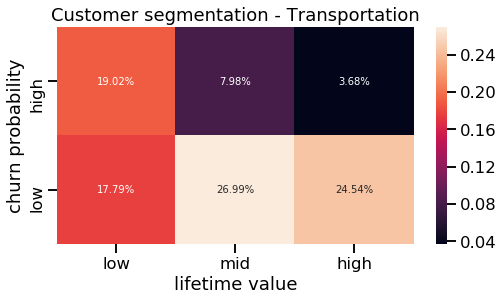

In [513]:
transport_customer_pivot = display_segmentation_matrix(
    df_transport_customer_summary,
    pivot_value_col='clv',
    pivot_index_col='churn_segment',
    pivot_col='clv_segment',
    plot_title='Customer segmentation - Transportation',
    plot_xlabel='lifetime value',
    plot_ylabel='churn probability'
)

### Food delivery

We conduct similar steps to food delivery customers.

In [518]:
from lifetimes.utils import summary_data_from_transaction_data

mask_food = (df_customer_transaction['product_type'] == 'FOOD')
df_food_customer_summary = summary_data_from_transaction_data(
    df_customer_transaction[mask_food],
    customer_id_col='account_id',
    datetime_col='order_completed_at',
    monetary_value_col='profit',
    observation_period_end=OBSERVATION_DATE
)

The expected monetary value from GammaGammaFitter fits well with the historical data.


    Expected conditional average profit: 5,871
    Average historical value: 5,600
    


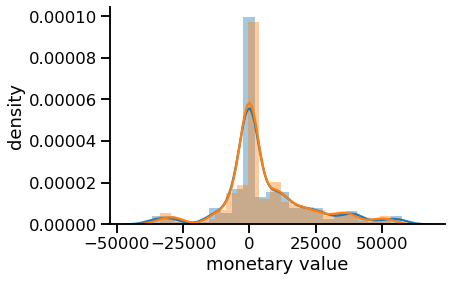

In [519]:
df_food_customer_summary, ggf_food = estimate_monetary_value(
    df_food_customer_summary,
    frequency_col='frequency',
    monetary_value_col='monetary_value'
)

In [520]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter

food_summary_calibration_holdout = calibration_and_holdout_data(
    df_customer_transaction[mask_food],
    customer_id_col='account_id',
    datetime_col='order_completed_at',
    monetary_value_col='profit',
    calibration_period_end='2019-11-30',
    observation_period_end=OBSERVATION_DATE
)

bgf_food = BetaGeoFitter(penalizer_coef=0.02)
bgf_food.fit(
    food_summary_calibration_holdout['frequency_cal'],
    food_summary_calibration_holdout['recency_cal'], 
    food_summary_calibration_holdout['T_cal']
);

In [521]:
df_food_customer_summary['clv'] = ggf_food.customer_lifetime_value(
    bgf_food,
    df_food_customer_summary['frequency'],
    df_food_customer_summary['recency'],
    df_food_customer_summary['T'],
    df_food_customer_summary['monetary_value'],
    freq='D',
    time=30,
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

Compared to transportation service, food delivery has **lower customer lifetime value**. Moreover, there is **~23% of customers with negative lifetime value.** As we see during the exploratory analysis, although the gross transaction amount is higher than transportation, food delivery gives much higher discount to the customers. *Is it the time to shift the strategy?* 

(-inf, 3999.385]        0.407692
(3999.385, 68321.77]    0.261538
(68321.77, inf]         0.330769
Name: clv, dtype: float64


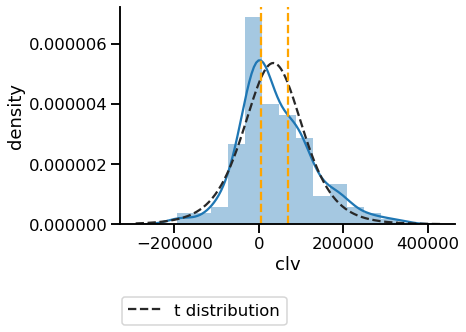

In [522]:
from scipy.stats import norm

food_clv = df_food_customer_summary['clv']

mask_food_clv_wo_outliers = (food_clv >= food_clv.quantile(.005)) & (food_clv <= food_clv.quantile(.995))
food_clv_wo_outliers = food_clv[mask_food_clv_wo_outliers]
cutoff1, cutoff2 = t.ppf([1/3, 2/3], *t.fit(food_clv[mask_food_clv_wo_outliers]))

df_food_customer_summary['clv_segment'] = pd.cut(
    food_clv, 
    [-np.inf, cutoff1, cutoff2, np.inf], 
    labels=['low','mid','high']
)

sns.distplot(
    food_clv.dropna(),
    fit=t,
    fit_kws={'label':'t distribution', 'linestyle':'--'}
)

plt.axvline(cutoff1, linestyle='--', color='orange')
plt.axvline(cutoff2, linestyle='--', color='orange')
plt.ylabel('density')

percentages = pd.cut(
    food_clv, 
    [-np.inf, cutoff1, cutoff2, np.inf]
).value_counts(True).sort_index()

plt.legend(loc='lower center', bbox_to_anchor=[.25,-.5])
sns.despine();

print(percentages)

Food delivery customers also have **more likelihood to churn**.

In [523]:
df_food_customer_summary['churn_prob'] = 1 - bgf_food.conditional_probability_alive(
        df_food_customer_summary['frequency'],
        df_food_customer_summary['recency'],
        df_food_customer_summary['T']
    )

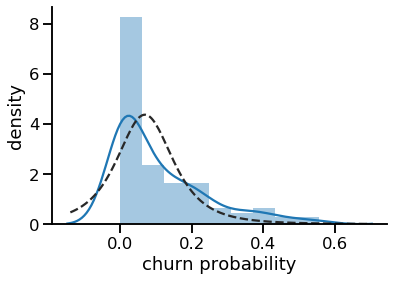

In [524]:
from scipy.stats import t

sns.distplot(
    df_food_customer_summary['churn_prob'],
    fit=t,
    fit_kws={'linestyle':'--', 'label':'t distribution'}
);

plt.xlabel('churn probability')
plt.ylabel('density')
sns.despine();

**Although there are ~30% of high-valued customers, half of them have high probability to churn**. We might need to focus on retaining them first, instead of focusing on the other segments. It is also interesting that **food delivery service only has ~15% of loyal customers** (low churn probability).

In [525]:
food_churn_prob = df_food_customer_summary['churn_prob']

mask_food_churn_prob_wo_outliers = (food_churn_prob >= food_churn_prob.quantile(.005)) & (food_churn_prob <= food_churn_prob.quantile(.995))
food_churn_prob_wo_outliers = food_churn_prob[mask_food_churn_prob_wo_outliers]
cutoff1, cutoff2 = t.ppf([1/3, 2/3], *t.fit(food_churn_prob[mask_food_churn_prob_wo_outliers]))

df_food_customer_summary['churn_segment'] = pd.cut(
    food_churn_prob, 
    [-np.inf, cutoff1, cutoff2, np.inf], 
    labels=['low','mid','high']
)

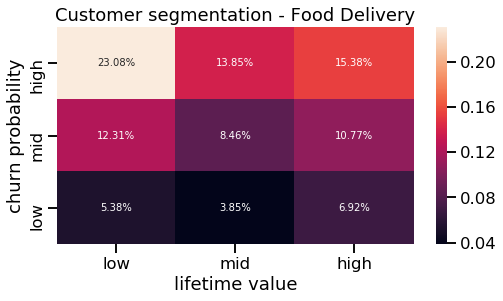

In [526]:
food_customer_pivot = display_segmentation_matrix(
    df_food_customer_summary,
    pivot_value_col='clv',
    pivot_index_col='churn_segment',
    pivot_col='clv_segment',
    plot_title='Customer segmentation - Food Delivery',
    plot_xlabel='lifetime value',
    plot_ylabel='churn probability'
)

# Takeaways

Both survival analysis and Buy 'Til You Die approach could help us to identify whether a customer is likely to churn. These approaches are based on statistical methods, and the outputs could be used as the target variable to build a machine learning model for customer churn prediction. In further works, we might be interested to find similarities in each customer segments.